In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import pandas as pd
import pickle

from TCGAMultiOmics.multiomics import MultiOmicsData
from moge.network.heterogeneous_network import HeterogeneousNetwork

from moge.visualization.plot_data import matrix_heatmap, bar_chart
from moge.network.edge_generator import DataGenerator
from moge.visualization.visualize_embedding import visualize_embedding, plot_bokeh_graph

from bokeh.io import output_notebook
output_notebook()

Using TensorFlow backend.


Loading BokehJS ...

#  Import network from file

In [2]:
with open('moge/data/luad_data_longest.pickle', 'rb') as file:
    luad_data = pickle.load(file)
#     network.multi_omics_data = luad_data
#     network_val.multi_omics_data = luad_data


In [3]:
from moge.network.heterogeneous_network import get_rename_dict
noncode_rename_dict = pd.Series(luad_data.LNC.noncode_func_df["Gene Name"].values,
     index=luad_data.LNC.noncode_func_df["NONCODE Gene ID"].str.split(".", expand=True)[0]).to_dict()
noncode_rename_dict = {k: noncode_rename_dict[k] for k in noncode_rename_dict if type(noncode_rename_dict[k])!=float}

lncbase_rename_dict = get_rename_dict(luad_data.LNC.get_genes_info(), "Gene ID")
lncbase_rename_dict.update(noncode_rename_dict)

In [4]:
# READ
with open('moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/LMN_lncbase_mirtarbase_biogrid_npinter_lncrna2target.train_v2.pickle', 'rb') as file:
# with open('moge/data/LMN_future_recall/TEST/Interactions_Affinity/LMN_lncbase_mirtarbase_biogrid_npinter_lncrna2target.latest.pickle', 'rb') as file:
    network = pickle.load(file)
    network.preprocess_graph()
    network.process_genes_info()
    network.G.remove_edges_from(network.G.selfloop_edges(data=True))
    
network.G.remove_edges_from([(u,v,d) for u,v,d in network.G.edges(data=True) if "database" in d and \
                             d["database"]=="NPInter" and u in network.nodes["GE"]])
network.G = nx.relabel_nodes(network.G, lncbase_rename_dict)

MIR  nodes: 1870
GE  nodes: 20157
LNC  nodes: 12706
Total nodes: 45856
Genes info columns: ['Disease association', 'locus_type', 'Transcript sequence', 'Chromosome', 'GO Terms', 'Family']


In [5]:
# READ edgelists
with open('moge/data/LMN_future_recall/TEST/Interactions_Affinity/LMN_lncbase_mirtarbase_biogrid_npinter_lncrna2target.test_v2.pickle', 'rb') as file:
    network_val = pickle.load(file)
    network_val.preprocess_graph()
    network_val.G.remove_edges_from(network_val.G.selfloop_edges(data=True))
    network_val.process_genes_info()
    
network_val.G.remove_edges_from([(u,v,d) for u,v,d in network_val.G.edges(data=True) if "database" in d and \
                             d["database"]=="NPInter" and u in network.nodes["GE"]])
network_val.G = nx.relabel_nodes(network_val.G, lncbase_rename_dict)

MIR  nodes: 1870
GE  nodes: 20157
LNC  nodes: 12706
Total nodes: 58986
Genes info columns: ['Disease association', 'locus_type', 'Transcript sequence', 'Chromosome', 'GO Terms', 'Family']


In [4]:
# with open('moge/data/luad_data_shortest.pickle', 'rb') as file:
#     luad_data = pickle.load(file)
#     network.multi_omics_data = luad_data
#     network.process_genes_info()

In [112]:
network.genes_info["Transcript length"] = network.genes_info["Transcript sequence"].apply(lambda x: len(x) if type(x) == str else None)
network.genes_info["Transcript length"].describe(percentiles=[.50, .75, .85, .90, .95, .99])

count    32741.000000
mean       791.396109
std       1132.424500
min         41.000000
50%        518.000000
75%        726.000000
85%       1112.000000
90%       1697.000000
95%       2553.000000
99%       5047.600000
max      91667.000000
Name: Transcript length, dtype: float64

# Data Visualization

In [7]:
# matrix_heatmap(network.get_adjacency_matrix(edge_types=["d"], node_list=network.node_list).todense())

In [8]:
# matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.node_list).todense())

In [9]:
# matrix_heatmap(network.get_adjacency_matrix(edge_types=["u_n"], node_list=network.node_list).todense())

In [10]:
# The test data to recall
# matrix_heatmap(network_val.get_adjacency_matrix(edge_types=["d"], node_list=network_val.node_list).todense())

# Train

In [11]:
params = {
    'd': 128, 
    'lr': 0.0005, 
    'margin': 1.0,
    'weighted': True,
    # 'subsample': True,
    'directed_proba': 1.0,
    'compression_func': 'log',
    'negative_sampling_ratio': 5.0,
    'max_length': 5050, 
    'truncating': 'random', 
    
    'conv1_kernel_size': 18, 
    'conv1_batch_norm': True,
    'max1_pool_size': 9, 
    'conv2_kernel_size': 6,
    'conv2_batch_norm': True,
    'max2_pool_size': 4, 
    'lstm_unit_size': 320, 
    'dense1_unit_size': 1024, 
    'dense2_unit_size': None, 
    'directed_distance': "euclidean",
    'undirected_distance': "euclidean",
    'source_target_dense_layers': False,
    'embedding_normalization': True
}

In [6]:
params = {'weighted': False,
 'undirected_distance': 'euclidean',
 'truncating': 'post',
 'source_target_dense_layers': True,
 'negative_sampling_ratio': 5.0,
 'max_length': 4500,
 'max2_pool_size': 6,
 'max1_pool_size': 9,
 'margin': 0.2,
 'lstm_unit_size': 100,
 'lr': 0.0005,
 'embedding_normalization': True,
 'directed_proba': 2.0,
 'directed_distance': 'euclidean',
 'dense2_unit_size': 512,
 'dense1_unit_size': None,
 'd': 128,
 'conv2_kernel_size': 6,
 'conv2_batch_norm': True,
 'conv1_kernel_size': 6,
 'conv1_batch_norm': True,
 'compression_func': 'linear'}


In [7]:
from moge.embedding.siamese_graph_embedding import SiameseGraphEmbedding
from moge.embedding.siamese_triplet_online_embedding import SiameseOnlineTripletGraphEmbedding

siamese = SiameseOnlineTripletGraphEmbedding(batch_size=225, margin=params["margin"], epochs=100, verbose=True)
# siamese = SiameseGraphEmbedding(batch_size=500, epochs=10, verbose=True)

# siamese = SiameseTripletGraphEmbedding(d=128, batch_size=256, margin=0.2, lr=0.001, epochs=30, 
#     negative_sampling_ratio=2.0, directed_proba=0.8, compression_func="sqrt3",
#     max_length=2000, truncating="post", verbose=True)

siamese.set_params(**params)

directed_margin 0.2 , undirected_margin 0.2


SiameseOnlineTripletGraphEmbedding(batch_size=225, compression_func='linear',
                  conv1_batch_norm=True, conv1_kernel_size=6,
                  conv2_batch_norm=True, conv2_kernel_size=6, d=128,
                  dense1_unit_size=None, dense2_unit_size=512,
                  directed_distance='euclidean', directed_proba=2.0,
                  embedding_normalization=True, epochs=100, lr=0.0005,
                  lstm_unit_size=100, margin=0.2, max1_pool_size=9,
                  max2_pool_size=6, max_length=4500,
                  negative_sampling_ratio=5.0, seed=0,
                  source_target_dense_layers=True, truncating='post',
                  undirected_distance='euclidean', verbose=True,
                  weighted=False)

In [13]:
import yaml
with open("logs/SiameseGraphEmbeddin_03-29_11-50PM/params.txt", "r") as file:
    params = yaml.load(str(file.read()))
    params["subsample"] = False
    siamese.set_params(**params)
    file.close()
    
siamese.load_model("logs/SiameseGraphEmbeddin_03-29_11-50PM/lstm_model.e5.h5", network)

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


Ed_count: 567219 , Eu_count: 907619 , En_count: 755846
Ens_count: 2836095
word index: {'A': 1, 'G': 2, 'T': 3, 'C': 4}
Embedding Tensor("embedding_1/embedding_lookup/Identity:0", shape=(?, ?, 4), dtype=float32, device=/device:GPU:0)
conv2D Tensor("lstm_lambda_2/Squeeze:0", shape=(?, ?, 320), dtype=float32, device=/device:GPU:0)
conv1d_2 Tensor("lstm_conv_2/Relu:0", shape=(?, ?, 192), dtype=float32, device=/device:GPU:0)
max pooling_2 Tensor("max_pooling1d_2/Squeeze:0", shape=(?, ?, 192), dtype=float32, device=/device:GPU:0)
brnn Tensor("bidirectional_1/concat_2:0", shape=(?, 640), dtype=float32, device=/device:GPU:0)
source Tensor("dense_source/BiasAdd:0", shape=(?, 64), dtype=float32, device=/device:GPU:0)
target Tensor("dense_target/BiasAdd:0", shape=(?, 64), dtype=float32, device=/device:GPU:0)
embedding Tensor("embedding_output/concat:0", shape=(?, 128), dtype=float32, device=/device:GPU:0)
Tensor("lstm_network/embedding_output/concat:0", shape=(256, 128), dtype=float32, device=/de

/opt/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
siamese.learn_embedding(network, network_val=network_val, 
                        multi_gpu=False, rebuild_model=False,
                        n_steps=2000, 
                        validation_steps=500,
                        tensorboard=True,
                        early_stopping=10,
                        initial_epoch=0,
                        seed=0),

labels_directed SparseTensor(indices=Tensor("labels_directed/indices:0", shape=(?, 2), dtype=int64, device=/device:GPU:0), values=Tensor("labels_directed/values:0", shape=(?,), dtype=float32, device=/device:GPU:0), dense_shape=Tensor("labels_directed/shape:0", shape=(2,), dtype=int64, device=/device:GPU:0))
labels_undirected SparseTensor(indices=Tensor("labels_undirected/indices:0", shape=(?, 2), dtype=int64, device=/device:GPU:0), values=Tensor("labels_undirected/values:0", shape=(?,), dtype=float32, device=/device:GPU:0), dense_shape=Tensor("labels_undirected/shape:0", shape=(2,), dtype=int64, device=/device:GPU:0))
Embedding Tensor("embedding_1/embedding_lookup/Identity:0", shape=(?, ?, 4), dtype=float32, device=/device:GPU:0)
conv2D Tensor("lstm_lambda_2/Squeeze:0", shape=(?, ?, 320), dtype=float32, device=/device:GPU:0)
conv1d_2 Tensor("lstm_conv_2/Relu:0", shape=(?, ?, 192), dtype=float32, device=/device:GPU:0)
max pooling_2 Tensor("max_pooling1d_2/Squeeze:0", shape=(?, ?, 192), 

# Visualize Embeddings

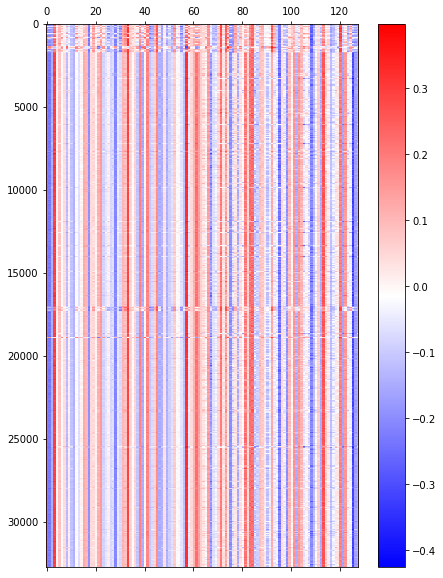

In [25]:
matrix_heatmap(siamese.get_embedding(recompute=True), cmap="bwr", aspect='auto', figsize=(7,10))

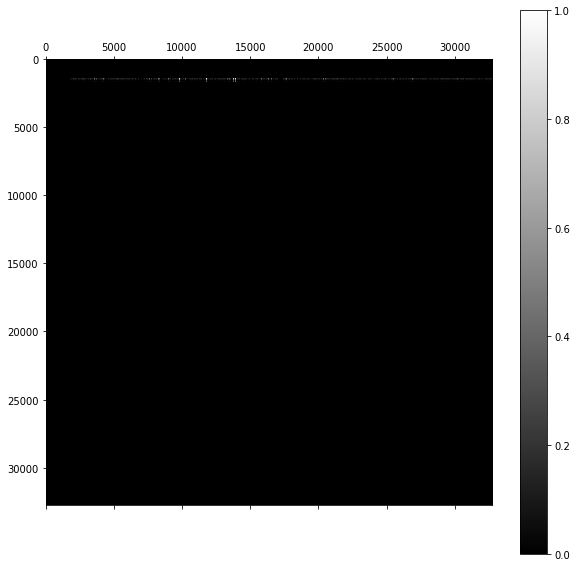

In [26]:
delattr(siamese, "reconstructed_adj") if hasattr(siamese, "reconstructed_adj") else None
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="d", 
#                                              interpolate=False,
#                                              node_l=siamese.generator_train.get_nonzero_nodelist(),
                                            ), figsize=(10, 10))

In [ ]:
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="u", 
#                                              node_l=siamese.generator_train.get_nonzero_nodelist(), 
                                             ), figsize=(10,10))

# Save Model & Embedding

In [ ]:
# siamese.save_model("lstm_model.h5", model="lstm", logdir=True)

In [ ]:
# siamese.truncating = "post"
# siamese.save_embeddings("lmn_train.triplet.shortest.biogrid.full.euclidean.trunc.emb", 
#                         variable_length=False, recompute=False, minlen=100)

In [ ]:
siamese.log_dir

# Import different models

In [63]:
from moge.embedding.static_graph_embedding import ImportedGraphEmbedding
from moge.embedding.sequence_based_embedding import BioVecEmbedding, iDeepVEmbedding, LncTarInteraction

nodelist = network.genes_info.index.tolist()

# biovec_emb = BioVecEmbedding(network, {"MIR": "moge/data/biovec/miRNA_protvec.model",
#                          "GE": "moge/data/biovec/mRNA_protvec.model",
#                          "LNC": "moge/data/biovec/lncRNA_protvec.model"})

node2vec_emb = ImportedGraphEmbedding(d=128, method_name="node2vec")
node2vec_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.node2vec.emb", 
                          node_list=nodelist)


biovec_emb = ImportedGraphEmbedding(d=100, method_name="BioVec")
biovec_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.biovec.emb", 
                          node_list=nodelist)

line_emb = ImportedGraphEmbedding(d=128, method_name="LINE")
line_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.line.emb", 
                          node_list=nodelist)

hope_emb = ImportedGraphEmbedding(d=128, method_name="HOPE")
hope_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.hope.emb", 
                          node_list=nodelist)

sdne_emb = ImportedGraphEmbedding(d=128, method_name="SDNE")
sdne_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.sdne.emb", 
                          node_list=nodelist)


rna2rna_emb = ImportedGraphEmbedding(d=128, method_name="rna2rna")
rna2rna_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lmn_train.siamese.multi_seq_UT.biogrid.full.euclidean.trunc.emb", 
                         node_list=network.node_list)
rna2rna_emb.network = network

print()

node2vec imported (21355, 128)
BioVec imported (32707, 100)
LINE imported (21355, 128)
HOPE imported (21355, 128)
SDNE imported (21355, 128)
rna2rna imported (32697, 128)



In [174]:
# rna2rna_graph = nx.from_numpy_matrix(rna2rna_emb.get_reconstructed_adj(), create_using=nx.DiGraph())

adaptive threshold
distance_threshold [0.06768363 0.05273433 0.05429796 ... 0.04959825 0.04959825 0.04959825]


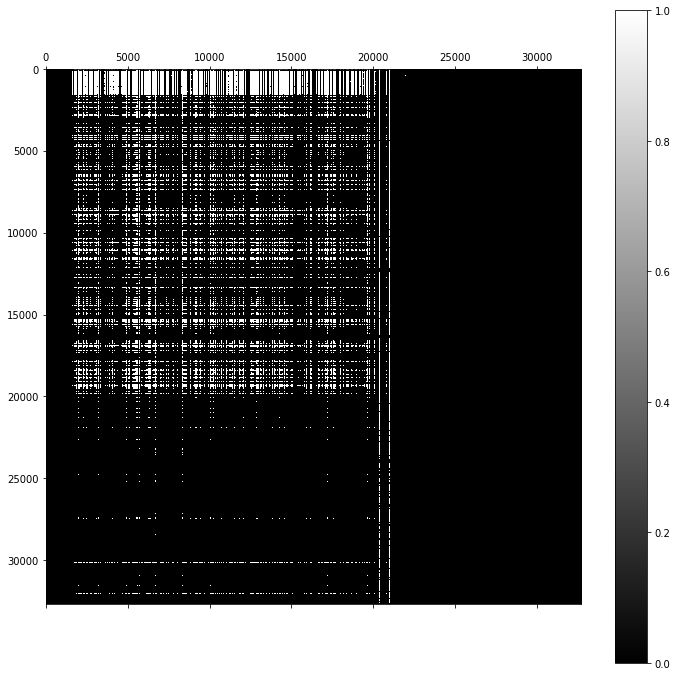

In [177]:
delattr(rna2rna_emb, "reconstructed_adj") if hasattr(rna2rna_emb, "reconstructed_adj") else None
matrix_heatmap(rna2rna_emb.get_reconstructed_adj())

In [64]:
methods = {}
methods["node2vec"] = node2vec_emb
methods["LINE"] = line_emb
methods["HOPE"] = hope_emb
methods["SDNE"] = sdne_emb
methods["BioVec"] = biovec_emb
# methods["rna2rna"] = rna2rna_emb
methods["rna2rna"] = siamese

# Prepare Validation Set

In [65]:
generator_val = DataGenerator(network=network_val, 
                             negative_sampling_ratio=1.0,
                             batch_size=1,
#                              maxlen=siamese.max_length,
                             truncating="post",
                             shuffle=True, seed=1,
                             training_network=network)
generator_val.on_epoch_end()

Ed_count: 269442 , Eu_count: 0 , En_count: 0
Ens_count: 269442
word index: {'A': 1, 'G': 2, 'T': 3, 'C': 4}


lncrna2target
Ed_count: 18013 , Eu_count: 0 , En_count: 0 , Ens_count 18013


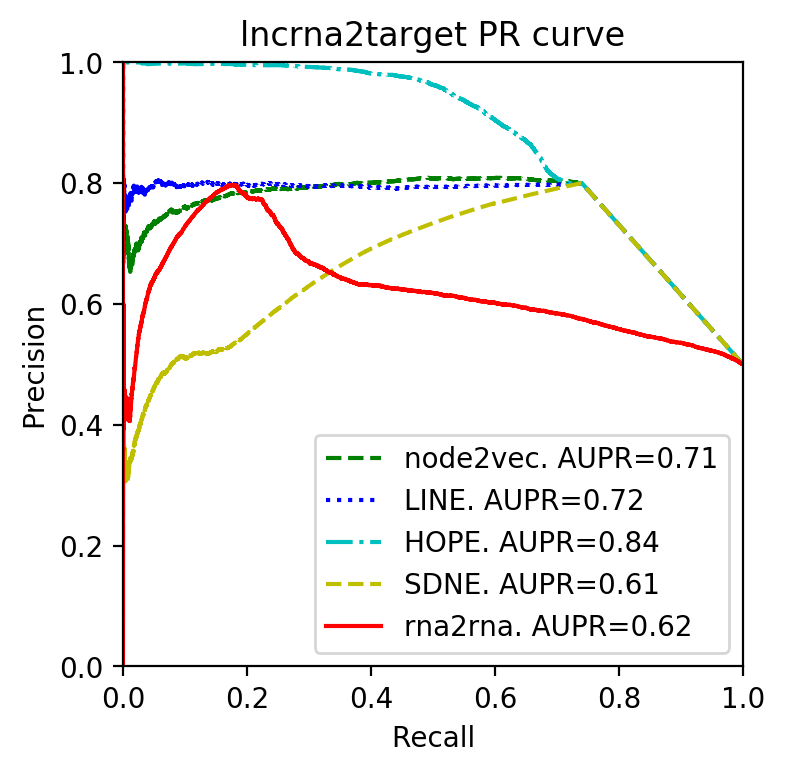

lncBase
Ed_count: 156149 , Eu_count: 0 , En_count: 0 , Ens_count 156149


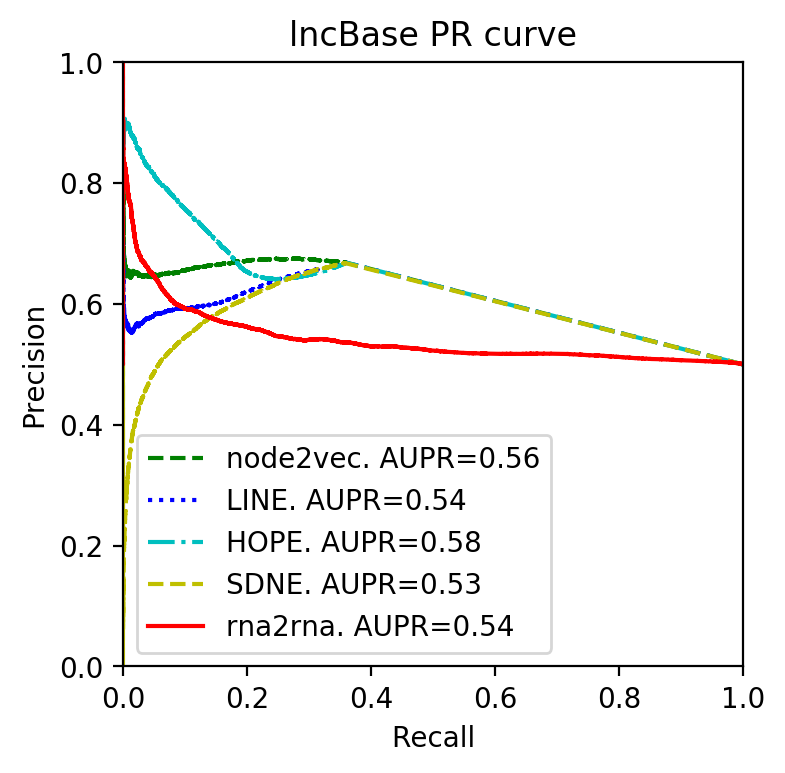

miRTarBase
Ed_count: 55891 , Eu_count: 0 , En_count: 0 , Ens_count 55891


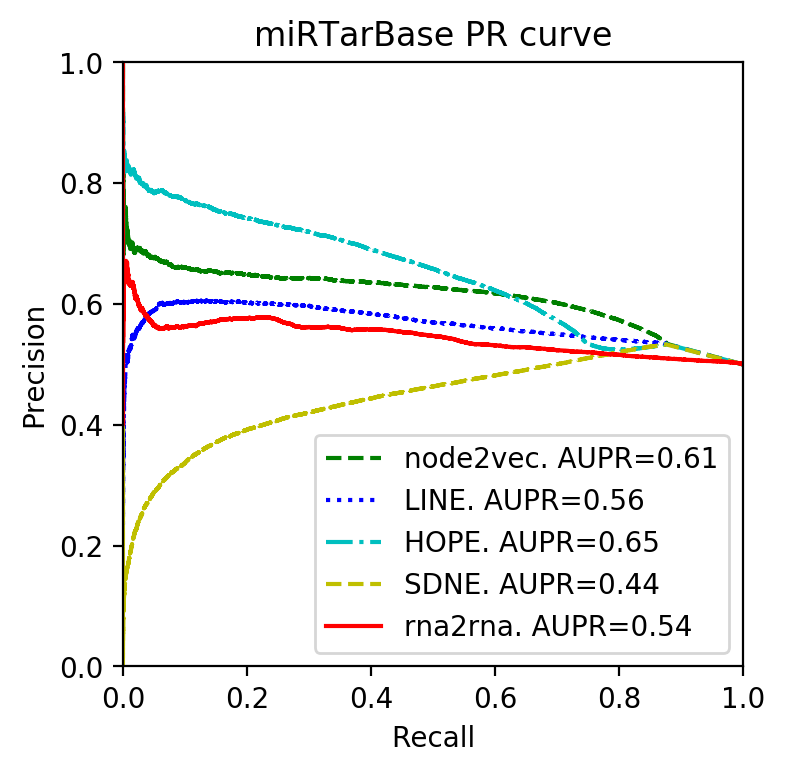

BioGRID
Ed_count: 31633 , Eu_count: 0 , En_count: 0 , Ens_count 31633


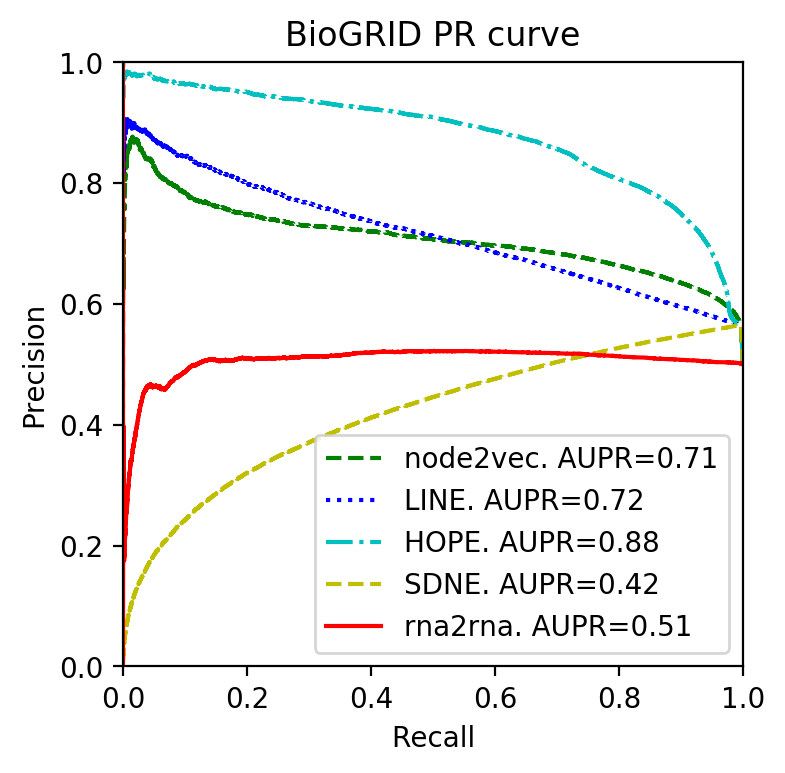

NPInter
Ed_count: 7756 , Eu_count: 0 , En_count: 0 , Ens_count 7756


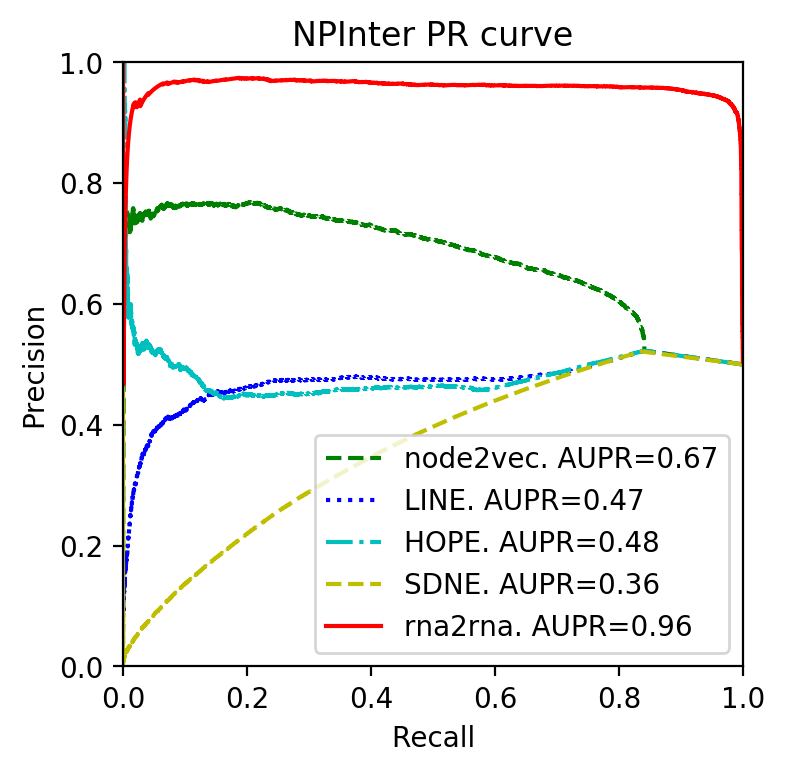

In [71]:
from moge.evaluation.link_prediction import evaluate_pr_curve_link_pred, evaluate_pr_curve_link_pred_by_database
# evaluate_pr_curve_link_pred(methods, X, y_true)
evaluate_pr_curve_link_pred_by_database(methods, generator_val, 
                                        tests=[
                                            ("LNC", "GE", "lncrna2target"),
                                            ("MIR", "LNC", "lncBase"),
                                            ("MIR", "GE", "miRTarBase"), 
                                            ("GE", "GE", "BioGRID"), 
                                            (None, None, "NPInter"),
#                                             ("LNC", "GE", "lncRInter"),
#                                             ("LNC", "GE", "LncReg"),
                                              ])

In [ ]:
novel_nodes = list(set(network_val.G.nodes()) - set(network.G.nodes()))
print(len(novel_nodes), {modality:len(set(novel_nodes) & set(network.nodes[modality])) for modality in ["LNC", "MIR", "GE"]})
novel_edges = list(network_val.G.edges(novel_nodes, data=True))
print(len(novel_edges))
# network_val.G.clear()
# network_val.G.add_edges_from(novel_edges)

# generator_val_novel = DataGenerator(network=network_val, 
#                              negative_sampling_ratio=1.0,
#                              batch_size=1,
# #                              maxlen=siamese.max_length,
#                              truncating="post",
#                              shuffle=True, seed=1,
#                              training_network=network)
# generator_val_novel.on_epoch_end()

# Prepare Training set (for graph reconstruction)

In [ ]:
from moge.network.edge_generator import DataGenerator

generator_train = DataGenerator(network=network, 
                             negative_sampling_ratio=1.0,
                             batch_size=1,
                             batch_size=1,
                             batch_size=1,
#                              maxlen=siamese.max_length,
                             truncating="post",
                             shuffle=True, seed=1)
generator_train.Eu_count = 0
generator_train.En_count = 0
generator_train.on_epoch_end()

In [ ]:
from moge.evaluation.link_prediction import evaluate_pr_curve_link_pred, evaluate_pr_curve_link_pred_by_database
# evaluate_pr_curve_link_pred(methods, X, y_true)
evaluate_pr_curve_link_pred_by_database(methods, generator_train, 
                                        tests=[("LNC", "GE", "lncrna2target"),
                                               ("MIR", "LNC", "lncBase"),
                                               ("MIR", "GE", "miRTarBase"), 
                                               ("GE", "GE", "BioGRID"), 
                                               (None, None, "NPInter"), 
                                              ])

# Experimental Results

In [33]:
from moge.evaluation.link_prediction import evaluate_top_k_link_pred

database_tests = [
    ("LNC", "GE", "lncrna2target"),
    ("MIR", "LNC", "lncBase"),
    ("MIR", "GE", "miRTarBase"), 
    ("GE", "GE", "BioGRID"), 
    # ("LNC", "GE", "lncRInter"),
    # ("LNC", "GE", "LncReg"),
]
top_k = 10000

for source, target, database in database_tests:
    print(database)
    results = {}
    for method in methods.keys():
        results[method] = \
              evaluate_top_k_link_pred(methods[method], network_train=network, network_test=network_val, 
                                       node_list=network.nodes[source], node_list_B=network.nodes[target], 
                                       edge_type="d", databases=[database], top_k=top_k)
        
    bar_chart(results, measures=['precision', 'recall'], 
              title="Top-k (k={}) Predictions on {}".format(top_k, database))

lncrna2target


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/embedding/static_graph_embedding.py:259: RuntimeWarning: overflow encountered in exp
  exps = np.exp(X)
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/embedding/static_graph_embedding.py:260: RuntimeWarning: invalid value encountered in true_divide
  return exps/np.sum(exps, axis=0)


MemoryError: 

In [74]:
hotair_edges = siamese.get_top_k_predicted_edges(edge_type="d", top_k=, 
                                  node_list=["HOTAIR"], node_list_B=network.nodes,
                                  training_network=network,)
len(hotair_edges)


NameError: name 'edge_type' is not defined

Clustering 23715 nodes with n_clusters: 24
Clustering 23715 nodes with n_clusters: 24
Clustering 23715 nodes with n_clusters: 24
Clustering 22270 nodes with n_clusters: 22
Clustering 32707 nodes with n_clusters: 24
Clustering 32741 nodes with n_clusters: 24


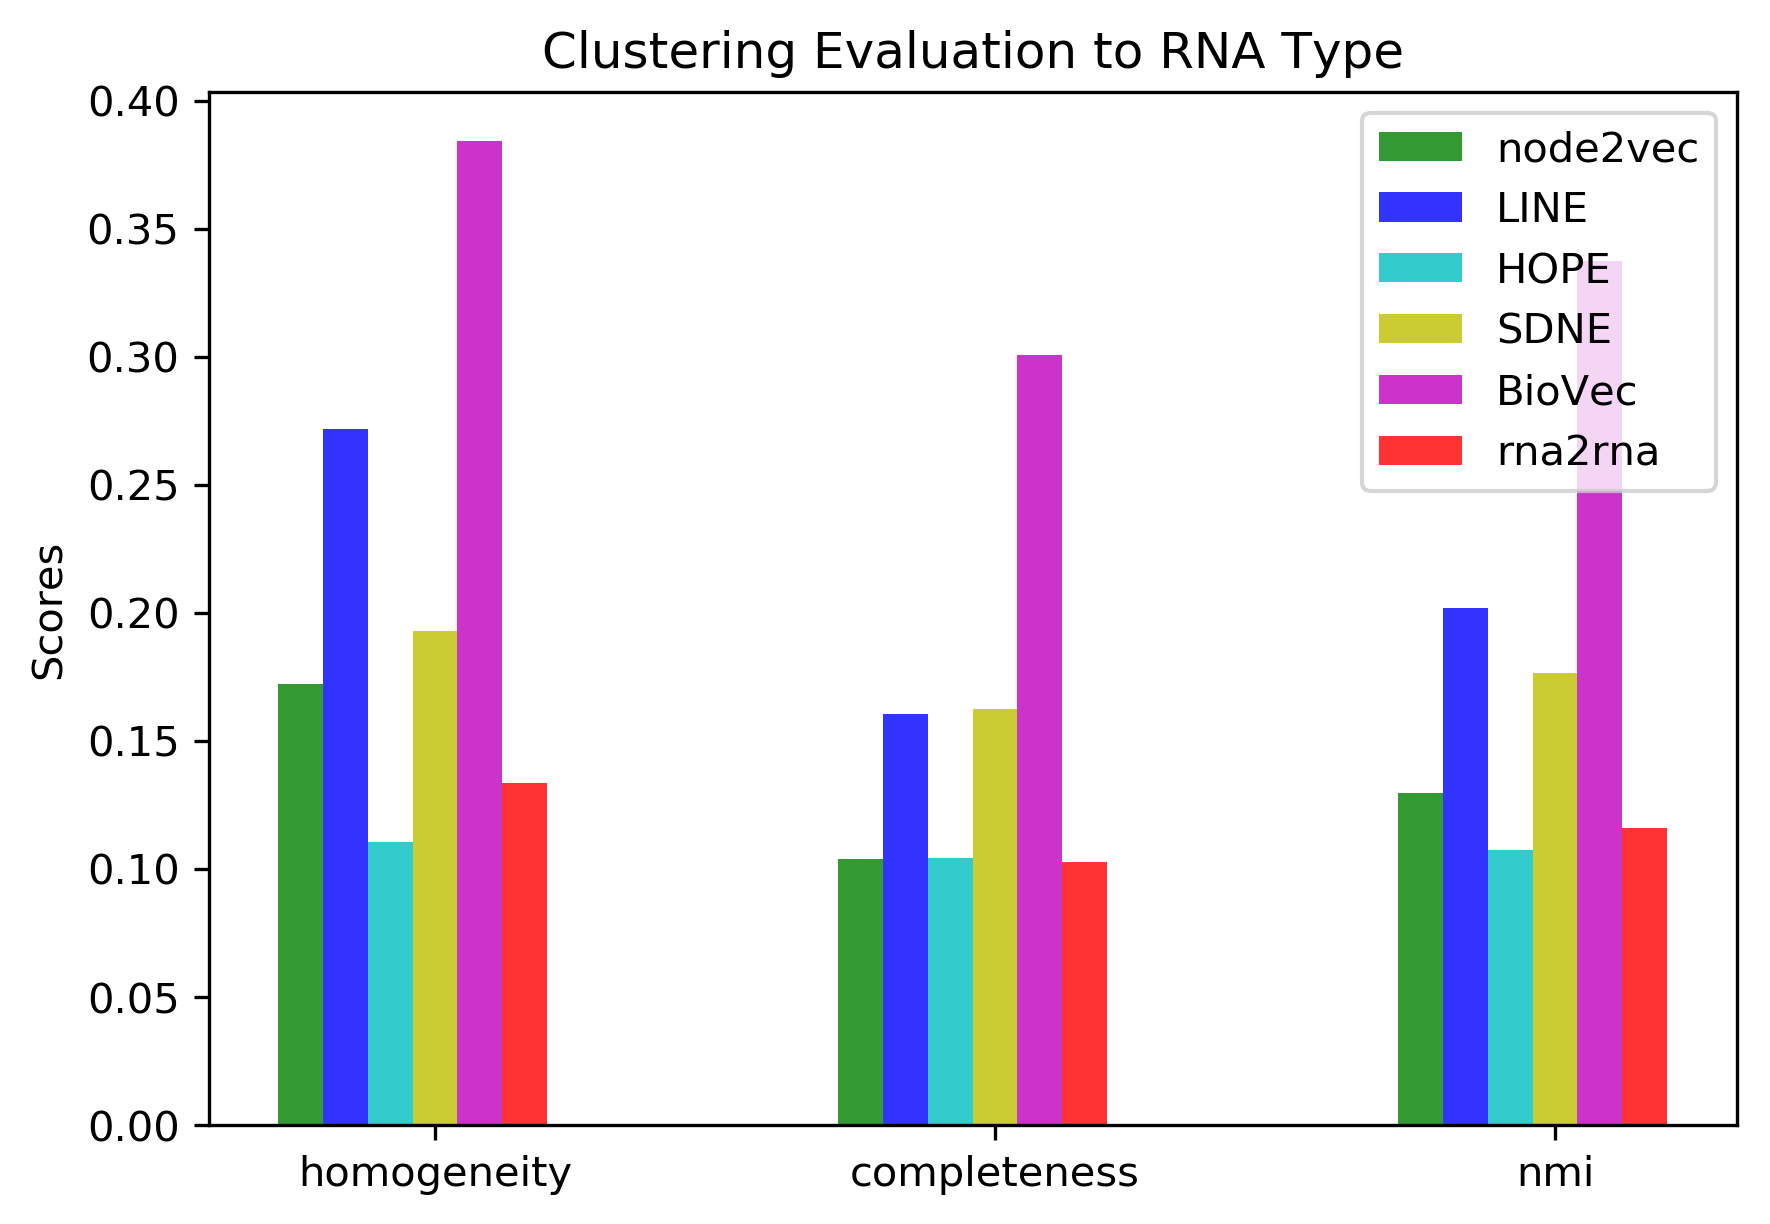

In [51]:
from moge.evaluation.node_clustering import evaluate_clustering

results = {}
for method in methods.keys():
    results[method] = evaluate_clustering(methods[method], network=network, node_label="locus_type", 
                                          max_clusters=500, n_clusters=None)

bar_chart(results, measures=['homogeneity', 'completeness', 'nmi'],
         title="Clustering Evaluation to {}".format("RNA Type"))

In [ ]:
from moge.evaluation.node_clustering import evaluate_clustering

results = {}
for method in methods.keys():
    results[method] = evaluate_clustering(methods[method], network=network, node_label="Family", 
                                          max_clusters=500, n_clusters=None)
    
bar_chart(results, measures=['homogeneity', 'completeness', 'nmi'], 
          title="Clustering Evaluation to {}".format("RNA Family"))

# of labels with >cv samples: 374 , # of nodes to train/test: 9710
# of labels with >cv samples: 374 , # of nodes to train/test: 10304
# of labels with >cv samples: 374 , # of nodes to train/test: 10304


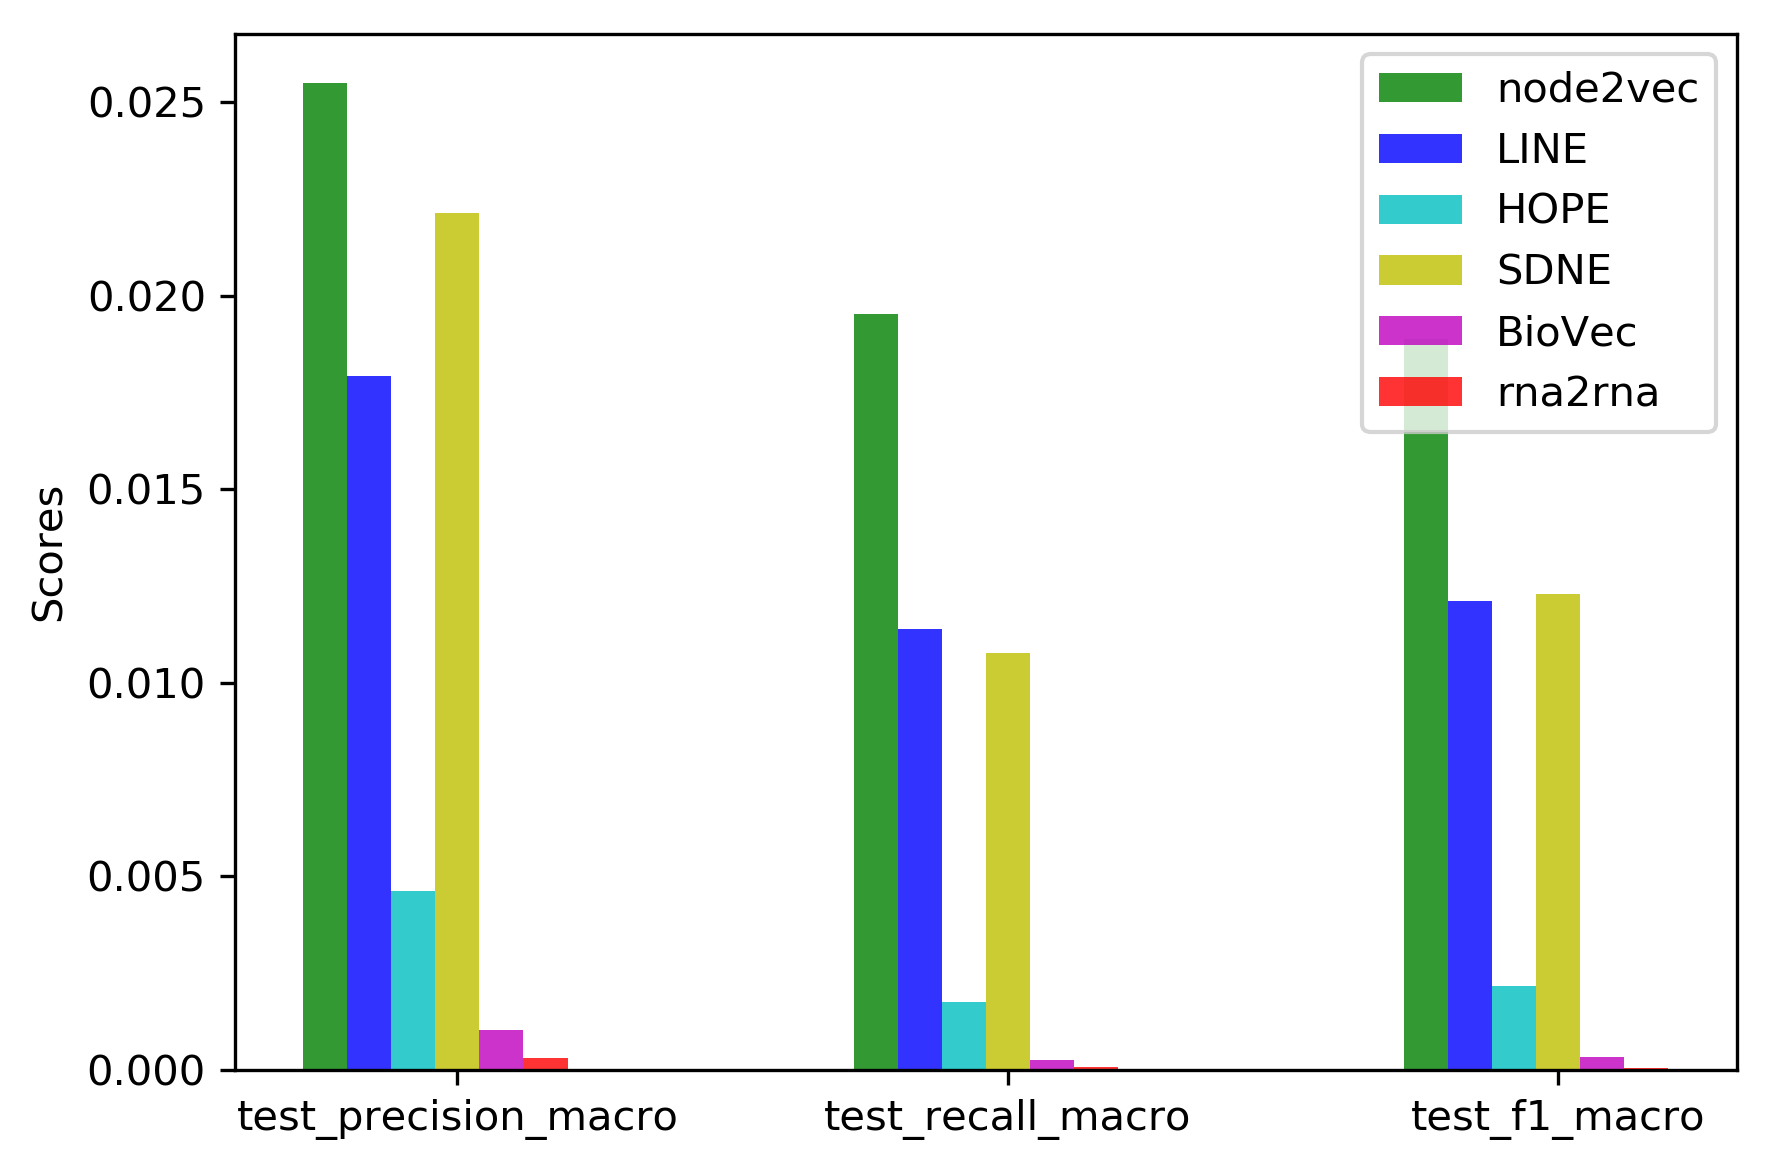

In [ ]:
from moge.evaluation.node_classification import evaluate_classification

results = {}
for method in methods.keys():
    result = {k: np.average(v) for k,v in evaluate_classification(methods[method], network, cv=10,
                                  node_label="Family", multilabel=True,
                                  scoring=['precision_macro', 'recall_macro', "f1_macro"],
                                                                verbose=True).items()}
    results[method] = result
    
bar_chart(results, measures=['test_precision_macro', 'test_recall_macro', 'test_f1_macro'])

In [ ]:
from moge.evaluation.node_classification import evaluate_classification

results = {}
for method in methods.keys():
    result = {k: np.average(v) for k,v in evaluate_classification(methods[method], network, cv=10,
                                  node_label="Disease association", multilabel=True,
                                  scoring=['precision_macro', 'recall_macro', "f1_macro"],
                                                                verbose=True).items()}
    results[method] = result
    
bar_chart(results, measures=['test_precision_macro', 'test_recall_macro', 'test_f1_macro'])

In [ ]:
from moge.evaluation.utils import get_scalefree_fit_score

results = {}
modalities = [("MIR", "LNC"), ("LNC", "MIR"), ("LNC", "GE"), ("MIR", "GE"), ("GE", "GE")]
labels = ["miRNA-lncRNA", "lncRNA-miRNA", "lncRNA-mRNA", "miRNA-mRNA", "mRNA-mRNA"]
databases = ["lncBase", "NPInter", "lncrna2target", "miRTarBase", "BioGRID"]

for method in ["Databases"]+list(methods.keys()):
    if method == "BioVec":
        continue
    elif method == "Databases":
        sub_result = {}
        for (A, B), label, database in zip(modalities, labels, databases):
            adj = network.get_adjacency_matrix(edge_types=["d"], 
                                               node_list=network.node_list,
                                               databases=[database,])
            network_degrees = np.sum(adj, axis=1)
            sub_result[label] = get_scalefree_fit_score(network_degrees, plot=False)
        results[method] = sub_result
    else:
        sub_result = {}
        for (A, B), label in zip(modalities, labels):
           sub_result[label] = methods[method].get_scalefree_fit_score(network.nodes[A], network.nodes[B])
        results[method] = sub_result
    
bar_chart(results, measures=labels, title="Scale-free fit scores", loc="lower right")

# Visualization

In [20]:
modalities = [("MIR", "LNC", "lncBase"), 
              ("LNC", "MIR", "NPInter"), 
              ("LNC", "GE", "lncrna2target"), 
              ("MIR", "GE", "miRTarBase"), 
              ("GE", "GE", "BioGRID")
             ]

nodes_inters_dict = {}
for A, B, database in modalities:
    edge_list = [(u,v,d) for u,v,d in network.G.edges(data=True) if "database" in d and d["database"]==database and\
                u in network.nodes[A] and v in network.nodes[B]]
    nodes_inters_dict[(A, B)] = {}
    nodes_inters_dict[(A, B)][A] = {u for u,v,d in edge_list}
    nodes_inters_dict[(A, B)][B] = {v for u,v,d in edge_list}

In [21]:
nodes_inters_dict_2 = dict.fromkeys(rna2rna_emb.node_list, 0)

for A, B, database in modalities:
    if database == "BioGRID": continue
    for node in nodes_inters_dict[(A, B)][A]:
        if node in nodes_inters_dict_2:
            nodes_inters_dict_2[node] = nodes_inters_dict_2[node] + 1
    for node in nodes_inters_dict[(A, B)][B]:
        if node in nodes_inters_dict_2:
            nodes_inters_dict_2[node] = nodes_inters_dict_2[node] + 1
        
trimodule_nodes = [k for k,v in nodes_inters_dict_2.items() if (k in network.nodes["LNC"] and v >= 2) or \
                   (k in network.nodes["MIR"] and v >= 2) or \
                  (k in network.nodes["GE"] and v >= 2)]
[(m, len(set(trimodule_nodes) & set(network.nodes[m]))) for m in ["LNC", "MIR", "GE"]]

[('LNC', 40), ('MIR', 561), ('GE', 275)]

In [31]:
set(trimodule_nodes) & set(network.nodes["LNC"])

{'A1BG-AS1',
 'AC005498.3',
 'AC006947.1',
 'AC007620.3',
 'AC009264.1',
 'AC009299.3',
 'AC010980.2',
 'AC012368.1',
 'AC017074.2',
 'AC020663.1',
 'AC025171.1',
 'AC027601.1',
 'AC099850.1',
 'AC131097.3',
 'AC132872.1',
 'AC156455.1',
 'ADPGK-AS1',
 'AFAP1-AS1',
 'AGAP1-IT1',
 'ALMS1-IT1',
 'ANKRD10-IT1',
 'ANKRD44-IT1',
 'AP000265.1',
 'AP001372.2',
 'ARHGAP22-IT1',
 'ASH1L-AS1',
 'ASMTL-AS1',
 'ATP6V0E2-AS1',
 'ATXN8OS',
 'BACH1-IT1',
 'BCDIN3D-AS1',
 'BHLHE40-AS1',
 'BOLA3-AS1',
 'CACTIN-AS1',
 'CASC15',
 'CASC2',
 'CBR3-AS1',
 'CDKN2B-AS1',
 'COX10-AS1',
 'CRNDE',
 'CTC-338M12.4',
 'CYTOR',
 'DACT3-AS1',
 'DANCR',
 'DAPK1-IT1',
 'DHRS4-AS1',
 'DICER1-AS1',
 'DIO3OS',
 'DLEU2',
 'DLGAP1-AS5',
 'EMX2OS',
 'ENTPD1-AS1',
 'EPB41L4A-AS1',
 'ERI3-IT1',
 'ERVK13-1',
 'FAM13A-AS1',
 'FAM87B',
 'FENDRR',
 'FGD5-AS1',
 'FLG-AS1',
 'FOXD2-AS1',
 'FOXP1-IT1',
 'FTX',
 'GABPB1-AS1',
 'GAS5',
 'GHRLOS',
 'GNAS-AS1',
 'GS1-124K5.4',
 'H19',
 'H1FX-AS1',
 'HAGLR',
 'HCFC1-AS1',
 'HCG11',
 'HCG1

In [60]:
g = network.G.subgraph(trimodule_nodes).to_undirected()
center_node = "CASC15"
nodelist = list(g.neighbors(center_node))+[center_node]
len(nodelist)

19

In [61]:
layout = nx.spring_layout(network.G.subgraph(nodelist), 
#                           weight='weight',
                          k=15.0/len(nodelist)**0.5,
                          iterations=100)

/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/visualization/visualize_embedding.py:134: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  node_labels = genes_info.loc[nodelist][node_label].str.split("|", expand=True)[0].astype(str)


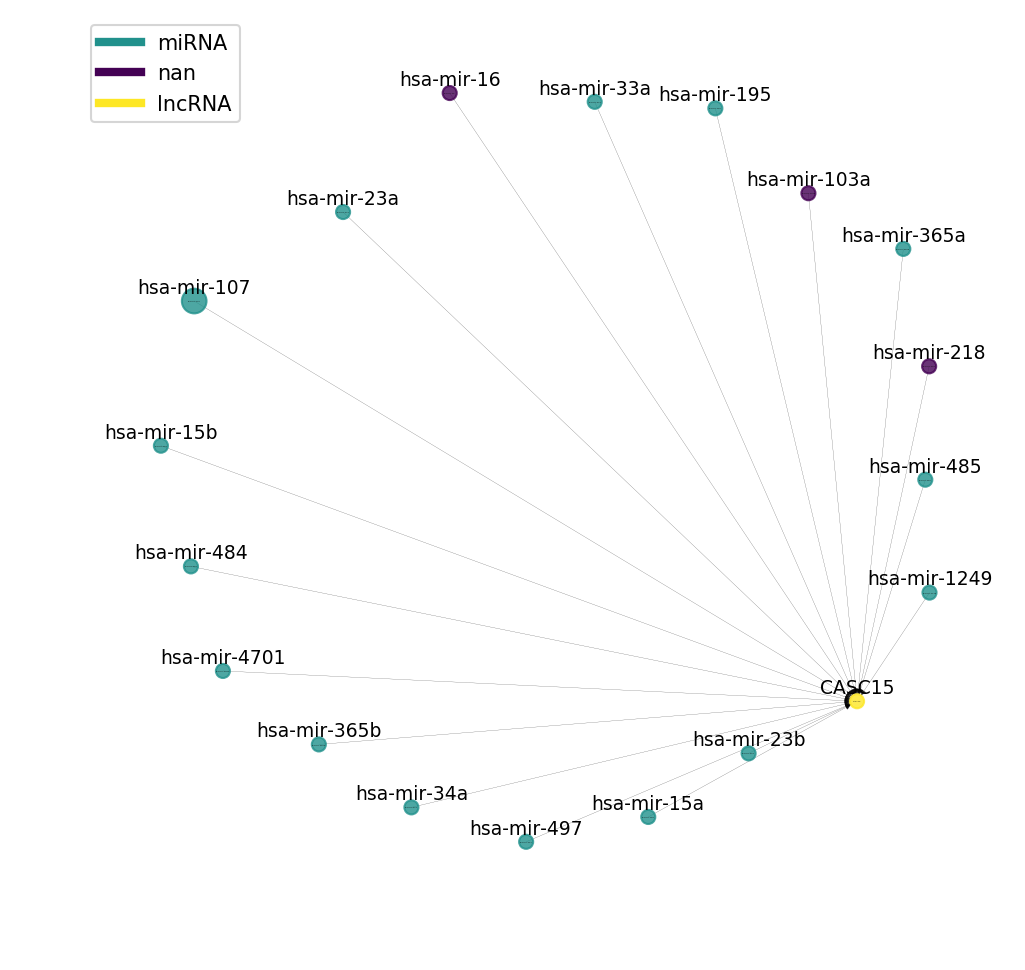

<Figure size 432x288 with 0 Axes>

In [62]:
visualize_embedding(rna2rna_emb, network=network, 
                    nodelist=nodelist,
                    node_label="RNA Type", # sc.tolist(), 
                    node_pos=layout,
                    top_k=0,
                    edgelist=network.get_edgelist(node_list=nodelist, inclusive=True),
#                     test_nodes=siamese.generator_val.get_nonzero_nodelist(),
                    cmap="viridis",
                    figsize=(8, 8), dpi=150,
                    with_labels=True, font_size=0, labels=None, arrowsize=6,
                    node_size="centrality", 
                    file_name="moge/data/Results/vis_lncRNAs/{}".format(center_node),
                   )

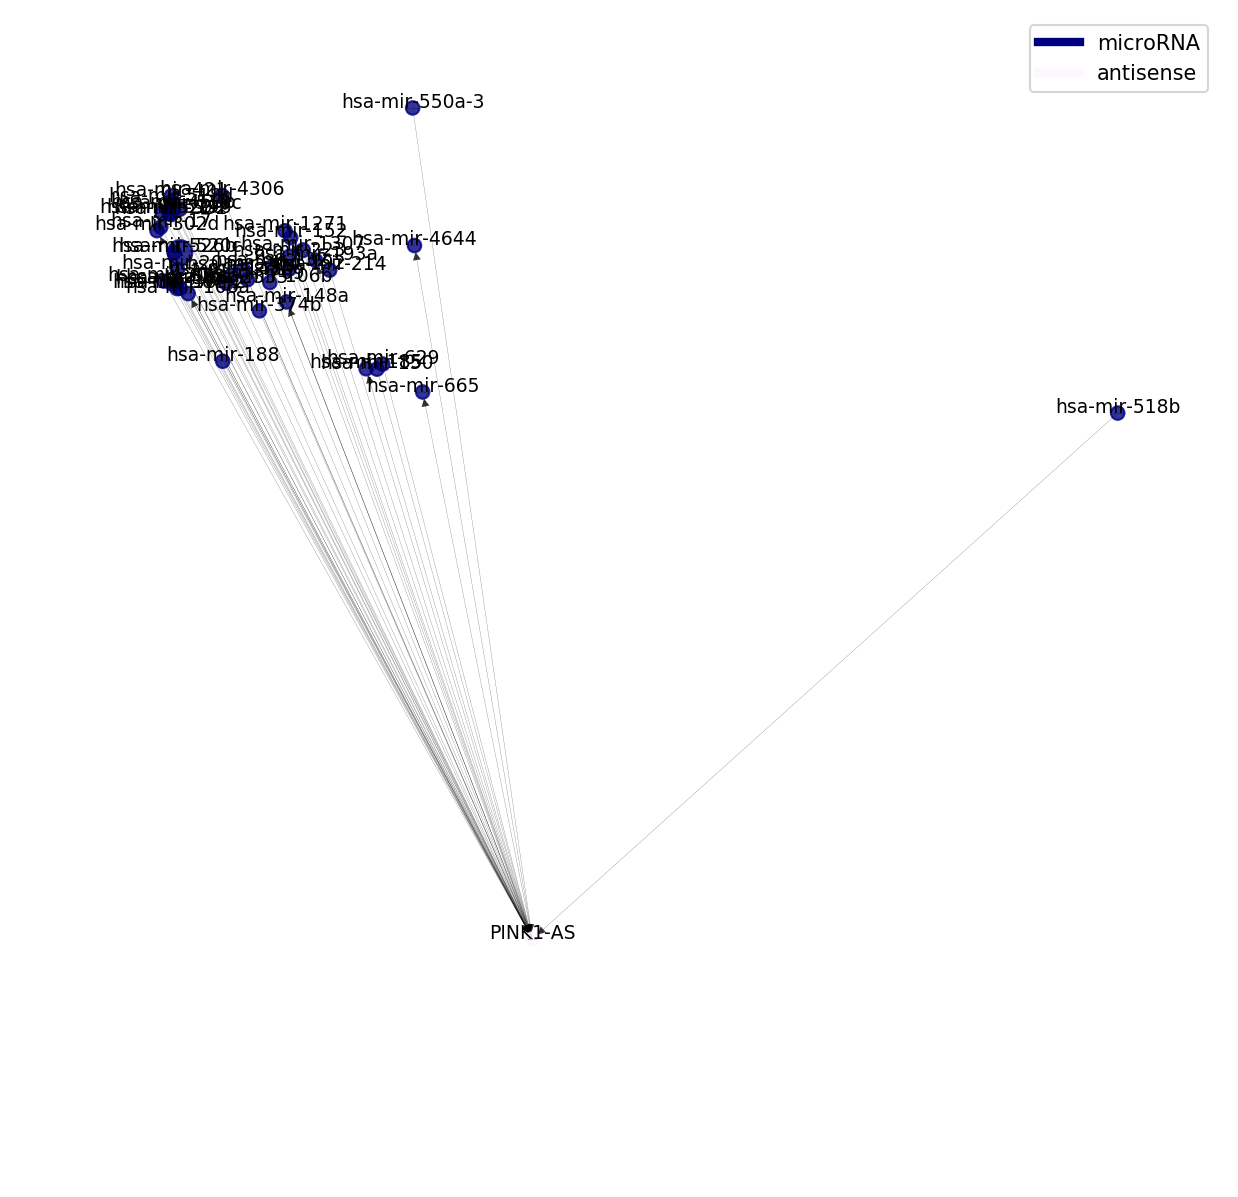

In [99]:
visualize_embedding(rna2rna_emb, network=network, 
                    nodelist=nodelist,
                    node_label="locus_type", # sc.tolist(), 
                    top_k=0,
                    edgelist=network.get_edgelist(node_list=nodelist, inclusive=True),
#                     test_nodes=siamese.generator_val.get_nonzero_nodelist(),
                    cmap="gist_ncar",
                    node_size="centrality", 
                    with_labels=True, font_size=0, labels=None, arrowsize=9,
                    figsize=(10,10), dpi=150,
#                     file_name="moge/data/Results/siamese_online_triplet_euclidean",
                   )

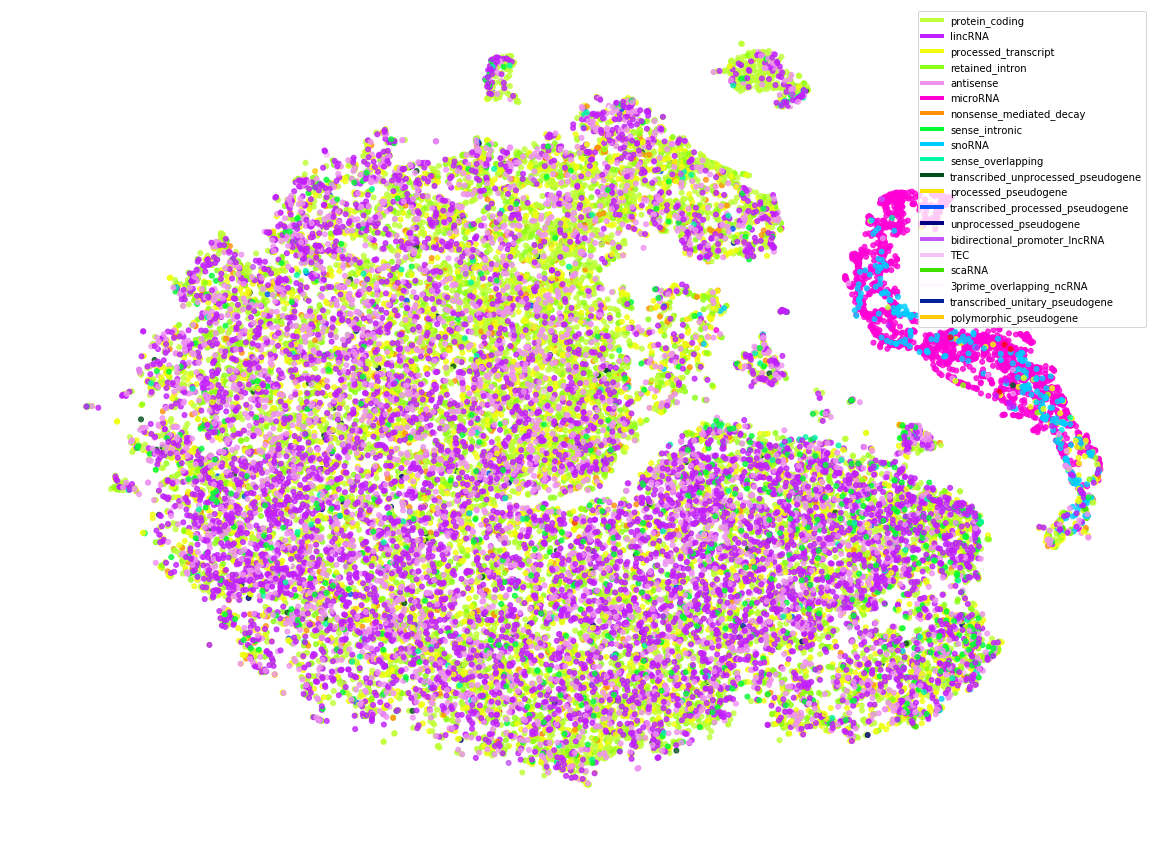

In [47]:
# siamese.process_embeddings(variable_length=True, minlen=200)
# delattr(siamese, "node_pos")
visualize_embedding(siamese, network=network, node_label="locus_type", 
#                     edgelist=network_val.get_edgelist(node_list=nodes_to_visualize, 
#                                                       edge_types=["d"])[:500],
#                     test_nodes=nodes_test,
                    cmap="gist_ncar",)

In [125]:
# nx.write_edgelist(network.G.subgraph(nodelist), "./moge/data/Networks/{}.edgelist".format(center_node))

In [118]:
plot_bokeh_graph(network.G.subgraph(nodelist), node_pos=layout,
                 node_label=network.genes_info.loc[nodelist, "locus_type"].values.tolist())

# AUC Rate

%%javascript
Jupyter.notebook.session.delete();